# Examples

In this notebook we'll show some examples of how you can analyse the YouTube data and use some data from other platforms. These are just some easy suggestions, for people that are not that familiar with Python and they are tailored to get a sense of what is happening in the data.

Interesting information could be:

1. Size of YouTube compared to other platforms.
2. Relative size of YouTube channels.
3. Nature and size of channels.
4. Growth of channels over time, for use in Gapminder.
5. Exploration with regex patterns of some topics discussed in the videos.
6. Exploration with regex patterns of user communities.

## Some considerations

- I used some predefined functions in scenariofunctions.py, to save some time. 
- The comment files (only provided on request) are difficult to parse because of the messy nature of the comments (many characters are used, so it's difficult to find reliable seperators). I therefore decided to use unusual, but rare seperators and quotechars. 
- Please configure the paths to your data in config.py. 
- Everything is coded in Python3

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import relevant libraries.

import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt 
import datetime as dt
import scenariofunctions as sf
import glob 
import csv 
import re
import sys
import os
import config

csv.field_size_limit(sys.maxsize)
%matplotlib inline

In [3]:
# Set paths to data. I've split the data into left, right and Dutch data. You can use the channel files for this.

path_nl = config.PATH_NL
path_right = config.PATH_RIGHT
path_left = config.PATH_LEFT
path_viz = config.PATH_VIZ

## Size of YouTube compared to other social media

Sources: 

1. [Mediamonitor 2018](https://www.cvdm.nl/wp-content/uploads/2018/06/Mediamonitor-2018-Reuters-Institute-Digital-News-Report-Nederland-2018.pdf)
2. [Marketingfacts](https://www.marketingfacts.nl/berichten/jongeren-keren-facebook-massaal-de-rug-toe)
3. [Pew research center](http://www.pewinternet.org/2018/05/31/teens-social-media-technology-2018/)



In [ ]:
# Marketingfacts, percentage that use...

data = {'WhatsApp':[97, 93, 86, 67, 38],
        'Facebook':[72, 89, 77, 69, 58],
        'YouTube':[86, 74, 54, 38, 21],
        'LinkedIn':[12, 45, 36, 14, 7],
        'Instagram':[73, 46, 22, 9, 6],
        'Twitter':[23, 26, 21, 9, 9],
        'Pinterest':[19, 30, 21, 12, 8],
        'Snapchat':[72, 32, 7, 1, 1]       
       }

marketingfacts = pd.DataFrame.from_dict(data, orient='index',
                             columns=['15-19 jaar', '20-39 jaar', '40-64 jaar', '65-79 jaar', '80+'])

In [ ]:
# Pew, percentage of teens that use...

data = {'Youtube': [85, 32],
        'Instagram': [72, 15],
        'Snapchat': [69, 35],
        'Facebook': [51, 10],
        'Twitter': [32, 3],
        'Tumblr': [9, 1],
        'Reddit': [7, 1],
        'Geen van bovenstaande': [3, 3]
       }

pew = pd.DataFrame.from_dict(data, orient='index',
                            columns=['Zegt te gebruiken', 'Zegt het meest te gebruiken'])

## Relative size of channels

Socialblade uses a propriety ranking system, based on view count, subscvriber count and some other metrics that are not public. These data can give you a sense of the relative size of channels. 

Some examples:

Volkskrant ranks:
- Grade: C+
- Subscriber rank: 1,001,161st
- Video view rank: 502,428th
- Socialblade rank: 523,376th
- Estimated Monthly Earnings: €29 - €459
- Estimated Yearly Earnings: €344 - €5.5K

De Correspondent ranks:
- Grade: C
- Subscriber rank: 1,832,426th
- Video view rank: 5,212,726th
- Socialblade rank: 4,469,657th
- Estimated Monthly Earnings: €0.47 - €8
- Estimated Yearly Earnings: €6 - €90

The New York Times ranks:
- Grade: B+
- Subcriber rank: 5,443rd
- Video view rank: 3,210th
- Socialblade rank: 8,201st
- Estimated Monthly Earnings: €5.2K - €82.4K
- Estimated Yearly Earnings: €61.8K - €989.2K


### Different information speres (left, right and Dutch compared)

In [ ]:
spheres = ['right', 'nl_right', 'left']
channel_rankings = pd.DataFrame()

for sphere in spheres:
    if sphere == 'nl_right':
        write_sphere = 'nl_right'
        path = config.PATH_NL
    elif sphere == 'left':
        write_sphere = 'left'
        path = config.PATH_LEFT
    elif sphere == 'right':
        write_sphere = 'right'
        path = config.PATH_RIGHT
    else:
        print('no valid sphere')

    socialblade_input = pd.read_csv(path + 'other_platforms/socialblade_' + sphere + '_summary.csv')
    socialblade = sf.socialblade_ranking(socialblade_input)
    socialblade['sphere'] = write_sphere
    channels_sphere = pd.read_csv(path + 'channels_' + sphere + '.csv', usecols=['channel_id','channel_title'])
    ranking = pd.merge(socialblade, channels_sphere, on='channel_id', how='left')
    channel_rankings = channel_rankings.append(ranking)

#Write to csv
#channel_rankings.to_csv(path_viz + 'socialblade_channel_rankings.csv')

### Growth of these spheres

Socialblade only has data going back to 2015. So it might be interesting to use the video metadata (view count for instance). The problem is that these metrics are not that reliable. A video from 2011 can still gather views. Sociablade gets monthly updates. But let's just try and see what happens, first with the socialblade data and second with the video data.

In [ ]:
spheres = ['right', 'nl_right', 'left']
channel_history = pd.DataFrame()

for sphere in spheres:
    if sphere == 'nl_right':
        write_sphere = 'nl_right'
        path = config.PATH_NL
    elif sphere == 'left':
        write_sphere = 'left'
        path = config.PATH_LEFT
    elif sphere == 'right':
        write_sphere = 'right'
        path = config.PATH_RIGHT
    else:
        print('no valid sphere')

    socialblade_input = pd.read_csv(path + 'other_platforms/socialblade_' + sphere + '_monthly.csv')
    socialblade = sf.socialblade_growth(socialblade_input)
    socialblade['sphere'] = write_sphere
    channels_sphere = pd.read_csv(path + 'channels_' + sphere + '.csv', usecols=['channel_id','channel_title'])
    growth = pd.merge(socialblade, channels_sphere, on='channel_id', how='left')
    channel_history = channel_history.append(growth, sort=False)
    channel_history = channel_history[['channel_title', 'yearmonth', 'subs', 'views', 'sphere']]

In [ ]:
#Write to csv and clear up some memory

channel_history.to_csv(path_viz + 'gapminder_monthly_growth_based_on_socialblade.csv', index=False)
del channel_history

You can find the gapminder file [Here](https://drive.google.com/open?id=16NFYBBD87ZP0o5Mm3z8j0RbucceAxq-i Of course you need gapminder itself, You can download that program [hier](https://www.gapminder.org/tools-offline/).

Some observations: 
1. It looks like somebody emptied a bucket of marbles. 
2. A couple of channels are really large. The Young Turks for instance. 
3. There is certainly a growth of channels, but that could coincide with a general growth of YouTube content. I've got the impression that on the right side, there are more channels of medium size, and more leftist channels that are small. 
4. 2016 and 2017 were important years for the growth of these channels.

We could take a subset to explore further:

- 'Stefan Molyneux', (well known and active since 2008)
- 'Red Ice TV', (popular, white nationalist)
- 'Millennial Woes', (difficult to establish if he's marginal or influential)
- 'Andywarski', (wouldn't call him extreme, but provides a platform (and a format) to host extremists)
- 'Alt-Right Tankie- Eurasianist', (hardcore alt-right)
- 'The Alternative Hypothesis', (ibidem, with many gaming references)
- 'Rebel Media', (professional, growing fast)
- 'Styxhexenhammer666', (more occultist, political commentary)
- 'Jean-Francois Gariépy', (French 'race realist')
- 'Gavin McInnes', (antifeminist, considerable news precense)
- 'Politiekman', (one of the few Dutch youtubers, recently quit)
- 'Black Pigeon Speaks', (popular channel)
- 'Paul Joseph Watson', (affiliated with the Alex Jones empire)
- 'The Thinkery', (philosophical, Sargon of Akkad)
- 'Sargon of Akkad', (big, anti-SJW, gamergate connection)
- 'American Rennaissance', (white supremacy)
- 'Pat Condell', (very popular in the Netherlands, but popularity there has waned)
- 'Vlad Tepesblog', (counter-jihadism, has been active for a long time)
- 'The Iconoclast', (hardcore alt-right)
- 'Dr. Steve Turley', (christian right)
- 'Black Pilled', (hardcore alt-right)
- 'Blonde in the Belly of the Beast', (female youtuber)
- 'Brittany Pettibone', (female, was denied entry to the UK)
- 'T Я U Σ Ð I L T O M', (british, uses fashwave style)
- 'AltRight.com' (Richard Spencer's channel)
- 'The Golden One' (Swedish alt-right, popular in the Netherlands)

In [ ]:
selection = ['Stefan Molyneux',
             'Red Ice TV',
             'Millennial Woes',
             'Andywarski',
             'Alt-Right Tankie- Eurasianist',
             'The Alternative Hypothesis',
             'Rebel Media',
             'Styxhexenhammer666',
             'Jean-Francois Gariépy',
             'Gavin McInnes',
             'Politiekman',
             'Black Pigeon Speaks',
             'Paul Joseph Watson',
             'The Thinkery',
             'Sargon of Akkad',
             'American Rennaissance',
             'Pat Condell',
             'Vlad Tepesblog',
             'The Iconoclast',
             'Dr. Steve Turley',
             'Black Pilled',
             'Blonde in the Belly of the Beast',
             'Brittany Pettibone',
             'T Я U Σ Ð I L T O M',
             'AltRight.com',
             'The Golden One'
]

In [ ]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)

In [ ]:
vids_we_want = sf.channel_filter(videos_right, set(selection))

In [ ]:
vids_grouped = vids_we_want.groupby(['video_channel_title', 'yearmonth'])[['video_view_count',
                                                                           'video_comment_count',
                                                                           'video_likes_count'
                                                                          
                                                                          ]].agg('sum')

In [ ]:
#Write to csv and clear some memory

vids_grouped.to_csv(path_viz + 'gapminder_monthly_growth_based_on_videos_selection.csv')
del vids_grouped
del vids_we_want
del videos_right

You can find the gapminder file [here](https://drive.google.com/open?id=18FUihglyZPN5v9fgMTB3tBZMUmR-oAfI) vinden.

Some observations:

It's clear that these channels get a large audience from 2013 onwards. Some channels, like Stefan Molyneux, were really marginal before that time, but became suddenly very popular very fast. I think Molyneux deserves his own analysis. 

Let's use the videos now.

In [ ]:
spheres = ['right', 'nl_right', 'left']
channel_history = pd.DataFrame()

for sphere in spheres:
    if sphere == 'nl_right':
        write_sphere = 'nl_right'
        path = config.PATH_NL
    elif sphere == 'left':
        write_sphere = 'left'
        path = config.PATH_LEFT
    elif sphere == 'right':
        write_sphere = 'right'
        path = config.PATH_RIGHT
    else:
        print('no valid sphere')

    videos = pd.read_csv(path + 'videos_' + sphere + '.csv', encoding='latin-1')
    videos = sf.add_years_months_to_videos(videos)
    videos['sphere'] = write_sphere
    channel_history = channel_history.append(videos, sort=False)

vids_grouped = channel_history.groupby(['video_channel_title', 'yearmonth', 'sphere']) \
                                        [['video_view_count',
                                        'video_comment_count',
                                        'video_likes_count'
                                        ]].agg('sum')

In [ ]:
vids_grouped.to_csv(path_viz + 'gapminder_monthly_growth_based_on_videos.csv')
del channel_history
del vids_grouped

In [376]:
growth = pd.read_csv(path_viz + 'gapminder_monthly_growth_based_on_videos.csv')

In [309]:
channels = growth.video_channel_title.unique().tolist()
len(channels)

1765

In [377]:
#chans_per_month = pd.DataFrame()

yearmonths = pd.date_range('2006-01', '2018-11', freq='MS').strftime("%Y-%m").tolist()

for m in yearmonths:
    for_df = {}
    for c in channels:
        for_df.update({c:m})
    df = pd.DataFrame(list(for_df.items()), columns=['channel', 'yearmonth'])
    df.to_csv(path_viz + 'test.csv', mode='a')
    

In [378]:
df = pd.read_csv(path_viz + 'test.csv')

You can find the gapminder file [here.](https://drive.google.com/open?id=1huuxSspihHlcRl3qs4YHuc_POE-Ho0Ie) 

There are a couple of outliers, but the growth of all these channels and the size of the right wing channels is impressive.

## What are the videos about?

Some topics to explore:
1. The manosphere
2. Race and IQ
3. Antisemitism
4. Antimuslim
5. Antirefugees / migration

Let's use the tags. Usually you don't see these tags as a user, but content makers are mindful of how they describe their content (it makes their content easier to find). Later on we can use some bigger guns, like topic modelling.

### Manosphere

First let's get a list of regex patterns with which we can find antifeminist and men rights' activists topics.

In [31]:
query_topic = 'manosphere'

query = ['mgtow', 'metoo', '^rape', 'rape cultur','proud boys', 'incel', 
         'pickup arti', 'rooshv', "men's right", 
         'men rights', 'manospher', 'mascul', 'hypergam', 
         'gynocentr', 'briffault', 'gold digg', 'whores', 
         'vagina', 'parasitic women', 'mens righ',
         'alpha fucks', 'misandry', 'alfa fux'
        ]


In [32]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 2941 videos with manosphere


So we have found 2941 videos with these patterns in their tags. What is their total viewcount?

In [ ]:
topic.video_view_count.sum()

More then 220 miljoen. It will probably be less if you remove metoo. We could make the selection of regex patterns a bit more extreme.

In [33]:
query_more_extreme = ['mgtow', '^rape', 'rape cultur','proud boys', 'incel', 
         'pickup arti', 'rooshv', 'manospher', 'hypergam', 
         'gynocentr', 'briffault', 'gold digg', 'whores', 
         'vagina', 'parasitic women',
         'alpha fucks', 'misandry', 'alfa fux'
        ]

In [34]:
topic_more_extreme = sf.topic_filter(videos_right, query_more_extreme, query_topic)

found 1857 videos with manosphere


In [35]:
topic_more_extreme.video_view_count.sum()

113965369.0

114 million views. Let's plot these views over time.

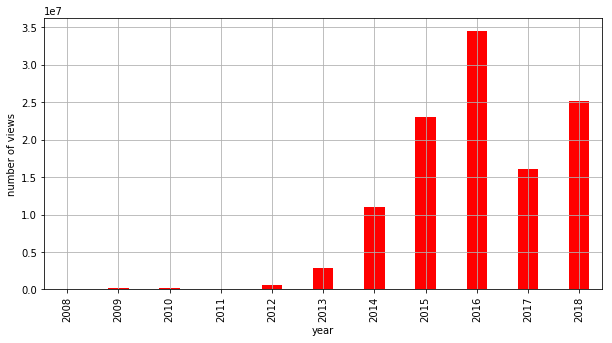

In [36]:
sf.plot_views_per_year(topic_more_extreme)

A peak in 2016, a sharp decline in 2017. What could this mean? 

Let's find the most watched channels then.

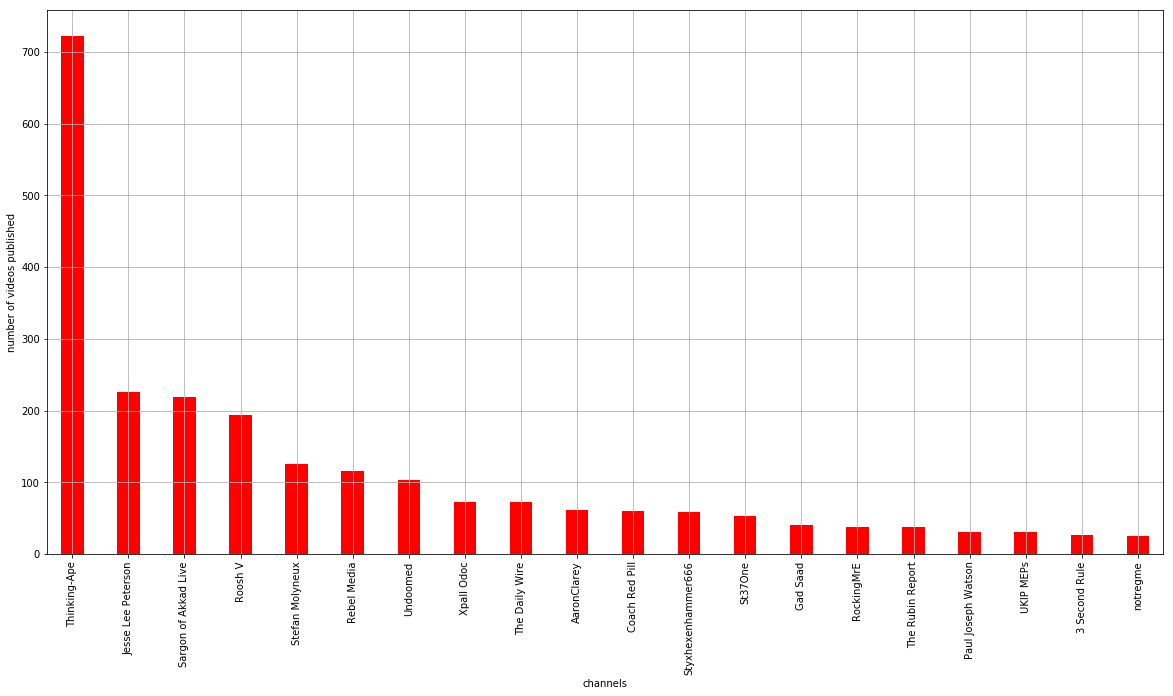

In [37]:
sf.plot_top_channels(topic)

It's clear where you should look if you want to explore this topic in depth: Thinking Ape. 

#### Manosphere - Thinking Ape

In [ ]:
channels_of_interest = ['Thinking-Ape']

manosphere = sf.channel_filter(topic, channels_of_interest)

How often have his videos been viewed?

In [ ]:
manosphere.video_view_count.sum()

Plot these over time.

In [ ]:
sf.plot_views_per_year(manosphere)

Let's have a look at the tags he uses.

In [ ]:
video_tags = sf.extract_tags(manosphere)

In [ ]:
video_tags.tag.value_counts()[0:40]

Even een verklarende woordenlijst:
    
1. Stardusk is [een YouTube-kanaal over MGTOW](https://youtube.com/user/Stardusk/videos). Het zou mij niets verbazen als dit ook van Thinking Ape is omdat hij zichzelf ook zo noemt.
2. Hypergamy is boven je stand trouwen, dus 'marrying up' of 'gold digging'. Zie [Wikipedia](https://en.wikipedia.org/wiki/Hypergamy).
3. Briffault's Law stelt, in hele simpele vorm, dat vrouwen eigenlijk de ultieme baas zijn (zie [dit artikel](https://www.psychologytoday.com/us/blog/machiavellians-gulling-the-rubes/201610/briffaults-law-women-rule) voor extra uitleg).
4. De naam zegt het eigenlijk al, bij gynocentrism draait alles om het gezichtspunt van de vrouw, zie [Wikipedia](https://en.wikipedia.org/wiki/Gynocentrism).
5. Male disposability, ook al zo'n deerniswekkend concept. Blijkbaar ook Male Expandability genoemd, zie [Wikipedia](https://en.wikipedia.org/wiki/Male_expendability).
6. Women initiate divorce slaat op de statistiek dat negentig procent van de echtscheidingen door vrouwen in gang wordt gezet. Zie bijvoorbeeld het [MGTOW-forum](https://www.mgtow.com/forums/topic/80-percent-of-divorces-are-initiated-filed-by-women/)

Meneer heeft trouwens 253 patrons [op patreon.](https://www.patreon.com/user?u=257125)

Al met al zijn die tags behoorlijk grof en vijandig. Opvallend dus ook: die tags is niet wat je in de normale interface van YT ziet. We zouden die tags ook nog over tijd kunnen plotten om iets van een ontwikkeling te zien. Ik weet niet of dat echt veel oplevert in dit geval, maar dan hebben we de code alvast om dat te doen.

Laten we eens naar wat video's gaan kijken. Ik maak een vrij expliciete selectie, bijvoorbeeld op 'whores'.

In [ ]:
lookup = sf.tag_filter(video_tags, 'whores')

In [ ]:
lookup.head()

Neem [deze video](https://www.youtube.com/watch?v=8EGN2KfFusM). Invasive species and Human Maladaptation. We zien niet veel. Een kaart van een Australie, met de titel: 'current extent and anticipated distribution of cane toads in australia'. De video gaat over de verdringingen van soorten door menselijk toedoen. Wat heeft dat met de tag 'whores' te maken? Verder is de video niet erg schokkend. Pas later in de video (zo rond 16:00 gaat het over psychologische maladaptation, dat steden bijvoorbeeld verantwoordelijk zijn voor echtscheidingen). Hoe vrouwen zich in stedelijke gebieden gedragen en hoe in rurale gebieden. 

Of [deze video](https://www.youtube.com/watch?v=_XaJHKl8kAY): MGTOW Talks: SJWs And the Blue Pill Rebellion in Gaming. Een gesprek van 1:20 uur, met een vaste gast (Australier en womanizer). Begint met de vraag of SJW's professionele trollen zijn. 'You can't appease these people'. Over gamergate en de Sarkeesian crowd. Opmerkelijke vorm ook: we zien de hele tijd een aankondiging voor een software conferentie. Waarom is dat? 

[Dit](https://www.youtube.com/watch?v=t8eTAsJVnNU) is ook wel een interessant voorbeeld. Lang (bijna twee uur durend gesprek), het is me niet helemaal duidelijk waar 'ie staat. Lijkt zich juist af te zetten tegen alt-right.

Aparte comment, lieflijk haast, spreekt wel over redpilling [zie](https://www.youtube.com/watch?v=Kx-4s1gGOkA&lc=UgjKEwvAkB7XkXgCoAEC)

#### Coach Red Pill

Komt ook vaak voor in de lijstjes. 

[Dit is zijn introvideo](https://youtu.be/tTOPkyeDsmE?t=40) - bijna 300.000 keer bekeken. De boodschap is duidelijk, vertrouw nooit een vrouw. Nooit. Er zit trouwens reclame op zijn zender. Ik kreeg ALPRO te zien. Er hangen overigens wel kindertekeningen in zijn studio. 

Ook over diversiteit, immigratie en racisme. Zie bijvoorbeeld [deze livestream](https://www.youtube.com/watch?v=3Q0K8Zai2xE) met That Guy T, Braving Ruins, Mauritian Struggle, Mouthy Buddha. 


#### Diana Davison

Ook interessant, een vrouw die meegaat in het MGTOW-frame. Zie bijvoorbeeld [deze video](https://www.youtube.com/watch?v=SddZvNQOuFw) (bijna 1,5 miljoen keer bekeken). Uit de beschrijving: 'There is no definitive list of techniques to how women manipulate men but you can see it in action. The case of Dalia Dippolito, caught hiring an assassin to kill her husband, produced really good footage of a woman in full manipulation mode. She was convinced that if she could get her husband physically close to her, she could blind him. And she's right. As long as men remain unaware of their vulnerability to female manipulation they will continue to be victims to it. The phenomenon of MGTOW (Men Going Their Own Way) is a good way to open your eyes. Feminism is bad but it's only a symptom of the bigger problem: gynocentrism and man's vulnerability to female charms. If you want to learn more about this phenomenon you'll find it on youtube: bar bar, JohntheOther, Spetsnaz, Sandman, ThinkingApeTV, RazorBladeKandy2 and others'

#### Turd flying monkey

Top 10 Things Only Red-Pill Men Understand About Women, ruim 600.000 views. 

#### Sandman

Ook best populair. [Deze introvideo uit 2014](https://www.youtube.com/watch?v=iVXdxaaRiAU) (ruim 600.000 keer bekeken) vat het wel aardig samen.

#### An Ear for Men

[Deze meneer](https://www.youtube.com/watch?v=eTSByNW8H_s) heeft ook wat issues...

#### Waar zitten de manospherians nog meer?

Wellicht is het interessant om te kijken naar de commenters. Waar zitten die nog meer? Is dit kanaal, vanuit het perspectief van de reaguurders, deel van een bredere gemeenschap?

Stap 1: even de video_id's in een lijst zetten.

In [ ]:
manosphere_movies = set(manosphere.video_id)
len(manosphere_movies)

Stap 2: haal deze lijst door alle comments in het rechtse veld om de reaguurders te vinden.

In [ ]:
fappers = sf.get_comments_by_video_id(manosphere_movies, 'right')

Bijna 64000 comments gevonden op de video's van Thinking Ape.

Stap 3. Zoek waar deze commenters nog meer hebben gereageerd, zodat we iets kunnen zeggen over de infosphere waar ze inzitten.

In [ ]:
fappers_to_search = set(fappers.author_channel_id.unique())
len(fappers_to_search)

In [ ]:
faposphere = sf.get_comments_by_author(fappers_to_search, 'right')

Van deze groep hebben we dus 1,3 miljoen comments gevonden. Waar zitten ze dan?

In [ ]:
fappers_united = pd.merge(faposphere, videos_right[['video_id', 
                                                    'video_channel_title',
                                                    'video_tags',
                                                    'video_view_count',
                                                    'video_comment_count']], on='video_id', how='left')

Waar zitten ze?

In [ ]:
sf.plot_top_channels(fappers_united)

Weinig verrassingen. Stefan Molyneux is wederom populair. Millennial Woes verbaasd me wel, evenals Jean Francois Gariepy. Zit dus lekker in de Alt-right.

Welke reaguurders vallen op?

In [ ]:
sf.plot_users(fappers_united)

Kijk eens aan. Hier komen we een aantal bekenden tegen, waaronder Mr.CoolMug die ook bij Erkenbrand actief is.
Een aantal anderen zijn ook prominent in de NL scene. Kan zijn dat ze overal prominent zijn en dus ook in de NL scene, maar het zou zo maar kunnen dat dit Nederlanders zijn. 

Ik ga eens kijken naar de ultime topfapper, Siim Land en wat zijn pad is in de Alt-right scene.

In [ ]:
siim = sf.zoom_in_on_commenter(fappers_united, 'Siim Land')

Even checken of het echt 1 en dezelfde persoon is.

In [ ]:
siim.author_channel_id.nunique()

Ja, er is maar een channel id. Die zijn uniek, dus we hebben hier met 1 persoon te maken, of beter gezegd, 1 account. Ik ga het even in [rawgraph](http://rawgraphs.io) bekijken. We hebben niet alle data nodig daarvoor, dus ik maak even een selectie.

In [ ]:
siim_grouped = siim.groupby(['year', 'video_channel_title'])['video_channel_title'].agg('count')
siim_grouped

Aha. Hij heeft zijn eigen kanaal waar hij erg actief is. Dat is dus niet zo interessant. Laten we dan maar Mr.CoolMug nemen. 

In [ ]:
mr_cool = sf.zoom_in_on_commenter(fappers_united, 'MrCool Mug')
mr_cool.author_channel_id.nunique()

In [ ]:
mr_cool_grouped = mr_cool.groupby(['year', 'video_channel_title'])['video_channel_title'].agg('count')
mr_cool_grouped

Oke, MrCool Mug zit zo'n beetje overal. Wel een interessante casus hoor. Zie een niet al te beste weergave van zijn ontwikkeling [hier.](https://drive.google.com/open?id=1wCQS-o85-FknSLovHJVjYiovGxH7TVQX) 

Laten we dan toch nog even op zoek gaan naar een hardcore mgtow-er die onder veel mgtow-video's reageert. We zoomen dus weer even uit naar de gemeenschap als geheel.

In [ ]:
manosphere = set(topic.video_id.unique())
fappers_total = sf.get_comments_by_video_id(manosphere, 'right')


In [ ]:
sf.plot_users(fappers_total)

Hmmm. Ik heb er een aantal geprobeerd, maar ik zie vooral dat sommige een eigen kanaal hebben waar ze veel op reageren. Anderen reageren veel op bekende kanalen. Tot nu toe niet echt interessante mensen kunnen vinden. To be continued.

#### Manosphere - Jesse Lee Peterson

Ik ben nog wel benieuwd naar een paar andere kanalen. Dus weer even inzoomen. Ik dacht zelf aan Jesse Lee Peterson en Roosh V. Ik begin met Jesse Lee Peterson, want die ken ik nog niet.


In [ ]:
channels_of_interest = ['Jesse Lee Peterson']

manosphere = sf.channel_filter(topic, channels_of_interest)

hoe vaak zijn zijn videos bekeken? 

In [ ]:
manosphere.video_view_count.sum()

In [ ]:
sf.plot_views_per_year(manosphere)

Duidelijk up and coming. Zeker laatste jaar flinke groei.

Laten we ook hier eens naar de tags kijken

In [ ]:
vidtags = sf.extract_tags(manosphere)

In [ ]:
lookup = sf.tag_filter(vidtags, 'masculinity')

In [ ]:
lookup

Bevindingen: het is een wat minder vulgair kanaal dan Thinking Ape. 

De beste man klinkt alsof hij dronken is. 

[Video:](https://www.youtube.com/watch?v=cTuFEJD0ggM) why should you forgive 'sexual assault'. Gaat over Asia Argento zaak. God wil dat je voor vergiffenis vraagt en niet zo moeilijk doet. Ik denk niet dat dit kanaal heel interessant is om vanuit de manosphere verder uit te zoek. Vrouwonvriendelijk en antifeministisch? Zeker. Maar interessanter denk ik vanwege de huidskleur van de presentator en omdat 'ie meer in het christelijke uiterst rechtse kamp lijkt te zitten. Dan krijg je al snel het antifemisme erbij.

Laten we daarom nu naar Roosh V kijken.

#### Manosphere - Roosh V

In [ ]:
channels_of_interest = ['Roosh V']

manosphere = sf.channel_filter(topic, channels_of_interest)
len(manosphere)

Hoeveel views heeft hij gekregen (op dit onderwerp?)

In [ ]:
manosphere.video_view_count.sum()

Toch nog ruim zeven miljoen.

In [ ]:
sf.plot_views_per_year(manosphere)

Lijkt wel over zijn piek heen. 

In [ ]:
vidtags = sf.extract_tags(manosphere)
vidtags.tag.value_counts()

Weinig interessants te vinden in zijn hashtags. Maar ik ben wel benieuwd naar zijn achterban.

In [ ]:
manosphere_movies = set(manosphere.video_id)
len(manosphere_movies)

In [ ]:
roosh = sf.get_comments_by_video_id(manosphere_movies, 'right')

hier gaat iets nog niet goed. nog ff checken. Ik wil niet te lang stilstaan bij de manosphere. Mochten we hier  verder mee willen, dan kunnen we er alsnog induiken.

In [ ]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')

### Ras & IQ

In [ ]:
query_topic = 'race'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['black lives matter', '^blm', 'white lives matter', '^wlm',
         'white genoci', 'replacement', '^race$', 'racist', 'rassis', 
         'racial', '^black$', 'diversity', 'richard spenc',
         '^white$', 'david duke', 'kkk', 'black peop', '^slaver',
         '^greg johns', '^blacks$', 'white ident', 'antiwhite', 'michael brown', 
         'white guilt', 'white privil', 'white suprema', '^realist$',
         '^ethnic', 'affirmative act', 'multiculturali', 'multikul', 'anti white',
        ]

In [ ]:
topic_more_extreme = sf.topic_filter(videos_right, query, query_topic)

### Eugenics

In [4]:
query_topic = 'eugenics'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['race realis', 'race and iq', 'race iq',
         'charles murray', 'bell curve', 'jared taylor', 
         'eugenics', 'galton', 'genetic', '^dna$',
        'american rennai', 'ancestry', 'amren', '^iq$',
        '^intelligence$']

In [5]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 1473 videos with eugenics


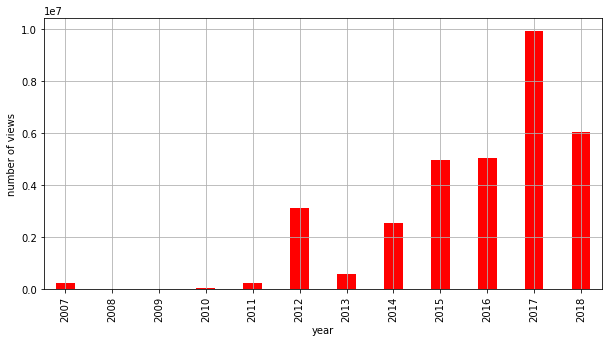

In [6]:
sf.plot_views_per_year(topic)

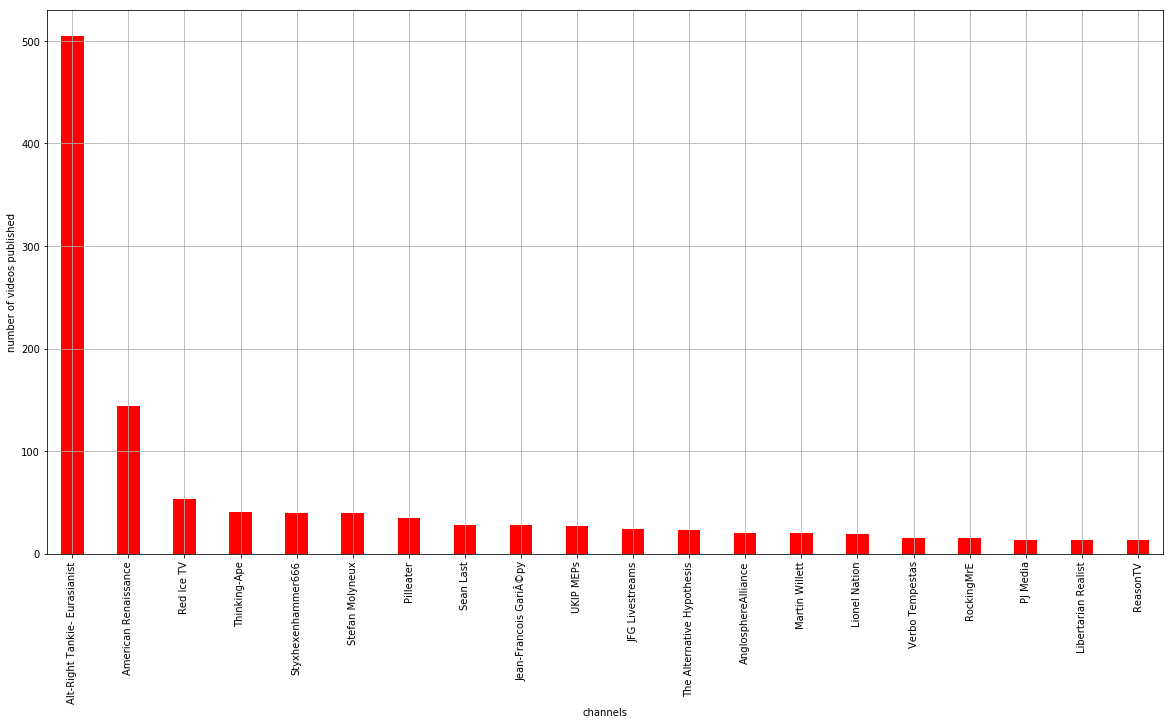

In [7]:
sf.plot_top_channels(topic)

In [13]:
tankie =  topic[topic['video_channel_title'] == 'Red Ice TV']
len(tankie)

53

#### Alt-Right Tankie - Eurasianist

Het is niet zo'n groot kanaal, maar ik kom 'm geregeld tegen, bijvoorbeeld in de achterban van Erkenbrand. Eurasianist verwijst naar Alexander Dugin, een Russische neofascist (kan je dat zo zeggen?). 
Met nog geen drieduizend subscribers niet zo groot. Video's halen vaak ook niet enorme aantallen. 

[De populaire uploads](https://www.youtube.com/channel/UCFWmmu2MmGW8Obc5pNDDJmw/videos?shelf_id=5&sort=p&view=0) halen enkele tienduizenden views, maar daar zit weinig eigen content bij. Gaat over Sam Harris, Geert Wilders, Douglas Murray. 
Geeft een platform aan neonazi (traditionalist worker party) Matt Heimbach.

[Dit interview bijvoorbeeld](https://www.youtube.com/watch?v=rC1_-2bdG8k) - slechts iets meer dan duizend views, maar wel hardcore fascisme, nationaal bolshewisme, etc. Gezien de geluidskwaliteit is die duizend views nog heel wat. Dit zijn de onderwerpen: Topics: -NSM moving towards Strasserism/Yockeyism & Nazbol sympathizing, Stalin, USSR, Jewry vs Great Russian power in USSR, Gulags, Holodomor, Katyn, Dr.'s Plot, Stalin's purges, Soviet support for anti-NATO & anti-Zionist causes, Otto E. Rememer, Stalin's break with Atlantist/ZOG forces. Sinead McCarthy's hatred for Christianity, Russia, Socialism, Dugin, Eurasianism, Orthodox Christian vs Islam & Jewry divide split in Eurasianism, ex-Yugoslavia, Caucasus, Cyprus, the Levant, Greece vs Turkey, Avidgor Eskin, Dogu Perincek

[Prachtige clip](https://www.youtube.com/watch?v=ne-ORhkM7OQ) om de knulligheid te laten zien. 

#### Dismantle The Matrix

Ook een apart kanaal, conspiracy meets ras en iq. Wat dacht je van [The Truth About Racial Inequality](https://www.youtube.com/watch?v=moWNOla7dpw&bpctr=1545141520). Wel achter een doorklik. Kanaal heeft meer dan 35.000 volgers.

Of [Leftists = Parasitic Subhuman Garbage](https://www.youtube.com/watch?v=A2-tZLEFHp0), 1455 views. Opgenomen in zijn auto.





### Antisemitisme

Ik hou de termen even beperkt. Als je bijvoorbeeld op Soros zoekt, krijg je erg veel terug dat mogelijk, maar niet per se antisemitisch hoeft te zijn. Daarom gebruik ik liever termen die minder dubbelzinnig zijn. Daarnaast lijkt het me verstandig om niet alleen in de tags te zoeken, maar ook in de beschrijvingen en comments. 

In [4]:
query_topic = 'antisemitism'

query = ['holohoax', '^jq', 'jewish question',
         '^zog', 'zionis', 'zion wa'
        ]

In [11]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 1529 videos with antisemitism


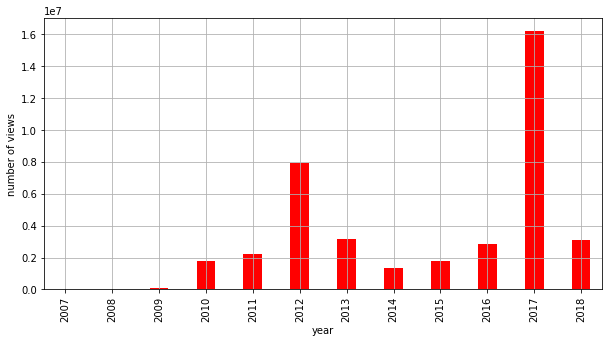

In [13]:
sf.plot_views_per_year(topic)

Wat een gekke verdeling. Klopt dit wel? 

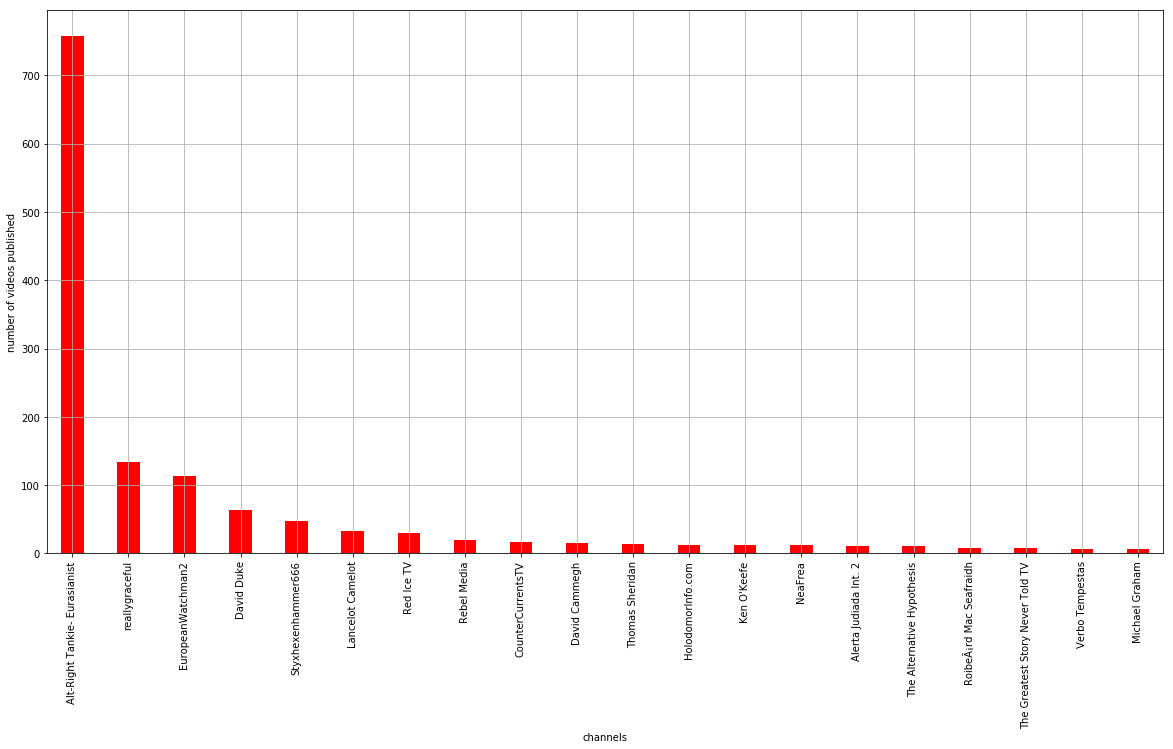

In [14]:
sf.plot_top_channels(topic)

Ik vermoed dat niet alle kanalen antisemitisch zijn. Ik zou eerder zeggen dat bijvoorbeeld Red Ice TV juist niet antisemitisch is, maar dat lijkt me iets om uit te zoeken. Sowieso is Alt-Right Tankie een erg interessant kanaal, ook omdat die populair is bij Erkenbrand. 

Dit zijn denk ik de stappen:
1. Eens kijken wat voor videos ik nu teruggekregen heb. Mogelijk moet ik de tags nog wat aanpassen.
2. De verschillende kanalen en hun achterban onderzoeken, in ieder geval de top3 en ik ben ook benieuwd naar FPO TV (misschien zit er iets in hun tags dat ze niet in het openbaar zeggen), Red Ice TV en Rebel Media.


Nogal wat videos gaan juist over antisemitsme op links.

In [15]:
rebel = topic[topic['video_channel_title'] == 'Rebel Media']
len(rebel)

20

In [16]:
rebel

,video_id,video_published,channel_id,video_title,video_description,video_channel_title,video_tags,video_category_id,video_default_language,video_duration,video_view_count,video_comment_count,video_likes_count,video_dislikes_count,video_topic_ids,video_topic_categories,year,yearmonth
201458,9DlixHBN95Y,2018-08-07T19:44:56.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,Rob Shimshock: Muslim RA Resigns After âPhys...,Rob Shimshock of Campus Unmasked isn't sure ho...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Rob Shi...",25.0,not set,PT3M21S,5360.0,118.0,431.0,13.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-08
201576,Clk60ismEVs,2018-07-25T21:01:42.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,Rob Shimshock: Muslim RA Says He Will âPhysi...,Rob Shimshock of Campus Unmasked wonders how I...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Rob Shi...",25.0,not set,PT2M56S,14110.0,267.0,855.0,27.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-07
201609,_vlqxmOZGvg,2018-07-23T20:07:03.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,"Am I a ""self-hating"" Muslim for visiting Israe...",Dr. Tanveer Ahmed just returned from a trip to...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Israel'...",25.0,not set,PT4M5S,6172.0,59.0,293.0,21.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-07
202030,g2P6c7u7hVk,2018-06-13T19:27:26.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,Prof Says Pro-Israel Students âNot Welcomedâ...,Rob Shimshock of Campus Unmasked reports on th...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Rob Shi...",25.0,not set,PT3M46S,9975.0,274.0,833.0,30.0,"['/m/098wr', '/m/05qt0', '/m/098wr', '/m/05qt0']","['https://en.wikipedia.org/wiki/Politics', 'ht...",2018,2018-06
202135,U0J-ND65YpA,2018-06-04T18:39:49.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,Pro-Palestinian Student Says Sheâll âF**k ...,Rob Shimshock of Campus Unmasked reports:\n\nT...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Rob Shi...",25.0,not set,PT3M53S,9697.0,286.0,934.0,50.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-06
202728,fC91pxUhBZU,2018-03-26T19:05:28.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,Prof: Welcoming Zionists Is A 'Declaration Of ...,Rob Shimshock of Campus Unmasked reports: \n\n...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Rob Shi...",25.0,not set,PT3M20S,9516.0,336.0,832.0,27.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-03
203429,g2P6c7u7hVk,2018-06-13T19:27:26.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,Prof Says Pro-Israel Students âNot Welcomedâ...,Rob Shimshock of Campus Unmasked reports on th...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Rob Shi...",25.0,not set,PT3M46S,9975.0,274.0,833.0,30.0,"['/m/098wr', '/m/05qt0', '/m/098wr', '/m/05qt0']","['https://en.wikipedia.org/wiki/Society', 'htt...",2018,2018-06
205801,6itXfwzxK1A,2017-02-16T23:30:24.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,"Jews facing double standard from media, politi...",Brian Lilley reports on recent cases of flagra...,Rebel Media,"['news', 'Rebel Media', 'RebelMedia', 'Canada'...",25.0,not set,PT5M57S,17711.0,599.0,998.0,282.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2017,2017-02
206125,Aa-PlLPNeOc,2017-01-06T15:26:02.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,The Right needs a dose of punk rock unity,(LANGUAGE WARNING:) Gavin McInnes of TheRebel....,Rebel Media,"['news', 'Rebel Media', 'alt right', 'conserva...",25.0,not set,PT6M41S,108432.0,1144.0,3446.0,457.0,"['/m/02jjt', '/m/02jjt']",['https://en.wikipedia.org/wiki/Entertainment'],2017,2017-01
206328,Lzp-Ch6K1tE,2016-12-02T21:40:09.000Z,UCGy6uV7yqGWDeUWTZzT3ZEg,Ryerson University students oppose Holocaust E...,Eitan Gilboord reports on a Student Union meet...,Rebel Media,"['news', 'conservative news', 'news today', 'R...",25.0,not set,PT5M41S,25344.0,726.0,882.0,729.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2016,2016-12


Bijvoorbeeld bij Rebel Media. Ik wil ook nog even Red Ice TV checken. Waarschijnlijk zien we daar hetzelfde

In [17]:
redice = topic[topic['video_channel_title'] == 'Red Ice TV']
len(redice)

30

In [18]:
redice

,video_id,video_published,channel_id,video_title,video_description,video_channel_title,video_tags,video_category_id,video_default_language,video_duration,video_view_count,video_comment_count,video_likes_count,video_dislikes_count,video_topic_ids,video_topic_categories,year,yearmonth
37430,KosAUH2JgCI,2018-09-26T01:24:48.000Z,UCFUC7NaTxZanB_FVOJN92eg,Third Temple in Jerusalem: Zionists Using Trum...,"Adam Green from ""Know More News"" joins Henrik ...",Red Ice TV,"['Third Temple', 'Judaism', 'Zionism', 'Christ...",25.0,not set,PT1H5M3S,105703.0,3177.0,3519.0,439.0,"['/m/05qt0', '/m/098wr', '/m/06bvp', '/m/098wr...","['https://en.wikipedia.org/wiki/Society', 'htt...",2018,2018-09
37448,S39ava7v19A,2018-09-03T22:41:44.000Z,UCFUC7NaTxZanB_FVOJN92eg,Is Israel Just Like Apartheid South Africa? - ...,"Arthur Kemp, author and veteran of the South A...",Red Ice TV,"['Radio 3Fourteen', '3Fourteen', 'Lana Lokteff...",25.0,not set,PT1H45S,18933.0,1170.0,1125.0,122.0,"['/m/05qt0', '/m/098wr', '/m/098wr', '/m/0f2f9']","['https://en.wikipedia.org/wiki/Politics', 'ht...",2018,2018-09
37515,QjmwYCu9TRo,2018-05-21T01:11:46.000Z,UCFUC7NaTxZanB_FVOJN92eg,The Sickening Opening Ceremony of the US Embas...,"Henrik looks at the symbolic, glaring ethnocen...",Red Ice TV,"['Red Ice TV', 'Israel', 'US Embassy', 'Jerusa...",25.0,not set,PT51M11S,29777.0,1625.0,1527.0,307.0,"['/m/05qt0', '/m/098wr', '/m/098wr', '/m/05qt0...","['https://en.wikipedia.org/wiki/Society', 'htt...",2018,2018-05
37599,9VfMVqDs-WA,2018-01-27T08:02:50.000Z,UCFUC7NaTxZanB_FVOJN92eg,Alfred Schaefer - Thought Criminal Monika Scha...,Alfred Schaefer is a German producer whose vid...,Red Ice TV,"['Red Ice TV', 'Alfred Schaefer', 'Monika Scha...",25.0,not set,PT54M25S,23339.0,865.0,1381.0,52.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-01
37700,HyRw2vAKxdI,2017-08-03T06:02:37.000Z,UCFUC7NaTxZanB_FVOJN92eg,Kevin MacDonald - The Importance of Understand...,Dr. Kevin MacDonald has a PhD in Biobehavioral...,Red Ice TV,"['Red Ice Radio', 'Red Ice TV', 'Kevin MacDona...",25.0,not set,PT53M55S,64201.0,700.0,2236.0,96.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2017,2017-08
37780,fkqTK09i-Xg,2017-05-02T12:22:14.000Z,UCFUC7NaTxZanB_FVOJN92eg,New âGeniusâ Show Sells Einstein as The Sm...,"National Geographic aired a new show, âGeniu...",Red Ice TV,"['Red Ice TV', 'Genius', 'Einstein', 'Smartest...",25.0,not set,PT31M33S,185579.0,3596.0,5320.0,1979.0,"['/m/0f2f9', '/m/02jjt', '/m/02jjt', '/m/0f2f9...",['https://en.wikipedia.org/wiki/Entertainment'...,2017,2017-05
37916,fpDeXVkZYvM,2016-11-23T09:49:10.000Z,UCFUC7NaTxZanB_FVOJN92eg,Daniel Hammarberg - Abrahamic Religion: The Da...,Daniel Hammarberg is a native Swede who has wr...,Red Ice TV,"['Red Ice Radio', 'Daniel Hammarberg', 'Abraha...",25.0,not set,PT55M26S,24770.0,268.0,463.0,101.0,"['/m/06bvp', '/m/098wr', '/m/098wr', '/m/06bvp']","['https://en.wikipedia.org/wiki/Religion', 'ht...",2016,2016-11
37924,IH9_1Cvk7Cs,2016-11-15T06:41:50.000Z,UCFUC7NaTxZanB_FVOJN92eg,John Lash - Eight Unifying Points for Truth Se...,"John Lash is a self-educated, free-lance schol...",Red Ice TV,"['Red Ice Radio', 'John Lash', 'Unifying Point...",25.0,not set,PT2H19M54S,22672.0,164.0,449.0,63.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2016,2016-11
37979,4xtdfU6PSBY,2016-08-29T06:41:50.000Z,UCFUC7NaTxZanB_FVOJN92eg,Germar Rudolf - Persecution of Revisionists & ...,"Germar Rudolf was born in Limburg, Germany. He...",Red Ice TV,"['Revisionism', 'Persecution', 'Holocaust', 'H...",27.0,not set,PT1H8M41S,12278.0,61.0,377.0,14.0,"['/m/098wr', '/m/05qt0', '/m/098wr', '/m/05qt0']","['https://en.wikipedia.org/wiki/Politics', 'ht...",2016,2016-08
37981,VuzQY1klxzo,2016-08-23T12:58:42.000Z,UCFUC7NaTxZanB_FVOJN92eg,"Red Ice Live - Michael Hoffman on ""Denial,"" ne...",This is an excerpt from the ninth episode of W...,Red Ice TV,"['Red Ice Live', 'Weekend Warrior', 'Michael H...",24.

Nou.... volgens mij is daar toch wel wat meer aan de hand... Maar goed dat we even gechecked hebben.

Wellicht is het een idee om een selectie te maken van kanalen die mogelijk antisemetische content herbergen. Ik stel voor om het bij 10 af te kappen, dus alle kanalen die 10 videos of meer hebben. Er zitten nogal wat conspiracy-achtige kanalen bij, maar dat is natuurlijk niet zo verwonderlijk.

Reallygraceful is een twijfelgeval. Ze heeft een aantal conspiracy videos, maar domineert de comments, wat de analyse nogal vertekent. Het is best nuttig om haar eens verder uit te diepen, maar dan apart, in een meer conspiracy achtige setting. Ik laat haar nu er even uit.

In [19]:
to_keep = ['Alt-Right Tankie- Eurasianist',
           'EuropeanWatchman2',
           'David Duke',
           'Red Ice TV',
           'CounterCurrentsTV',
           'David Cammegh',
           'HolodomorInfo.com',
           'NeaFrea',
           "Ken O'Keefe",
           'The Alternative Hypothesis',
           'Alerta Judiada Int. 2',
           'Esoteric Truths',
           'Verbo Tempestas',
           'RoibeÃ¡rd Mac Seafraidh',
           'Electre',
          ]

In [20]:
antisemites = sf.channel_filter(topic, to_keep)

deze selectie levert 1081 videos op.


In [21]:
antisemites.video_channel_title.value_counts()

Alt-Right Tankie- Eurasianist    758
EuropeanWatchman2                113
David Duke                        64
Red Ice TV                        30
CounterCurrentsTV                 17
David Cammegh                     16
HolodomorInfo.com                 13
NeaFrea                           12
Ken O'Keefe                       12
The Alternative Hypothesis        11
Alerta Judiada Int. 2             11
RoibeÃ¡rd Mac Seafraidh            8
Verbo Tempestas                    7
Esoteric Truths                    7
Electre                            2
Name: video_channel_title, dtype: int64

#### Red Ice TV

Laten we eens naar **Red Ice TV** kijken. 

Deze is wel interessant: [Tim Murdock - The War on Whites](https://www.youtube.com/watch?v=j5tJAo6T9E8) (bijna 60.000 views). Intervierw is Lana Lokteff, gast is Tim Murdock, man achter de white rabbit meme (opzoeken). Begint met een tirade, vol conspiracy theories en totale overdrijvingen over hoe het witte ras wordt gemuilkorfd, terwijl allerlei tuig uit Derde Wereld landen mogen verkrachten, moorden, etc. Behoorlijk millitante toon. 'Clean out zionist rats from the government who seeks to destroy us'. 
- Jewish intellectuals
- Obama hates whites
- White children are beaten by gangs of foreigners and everybody looks the other way
- 80 year old white women are reaped with broken bottle
- Sweden, where white women are raped by foreigners and the legal system looks the other way. Why is this not anti-white?
- Who is allowing the lowest of the low to do whatever they whish, while we are muzzled by hate speech laws.
- Freud the hailed jewish psychologist, jewish supremacist
- White are denied jobs, schools and loans
- White race traitors who suffer from pathological disease

Eerste vraag aan Murdock: what are your roots. Europe of course.

Of meer conspiracy achtig. [David Icke - Origins of Israel & New Mono World Order](https://www.youtube.com/watch?v=RlGvrnup3fM). David Icke is een prominente Engelse conspiracy theorist. Toch nog ruim 22.000 views. 
Totaal maffe analyse. De gehele orde in Midden-Oosten door 'global cabal' opgeblazen om nieuwe orde te scheppen. Anti-joodse imagery zegt genoeg.

Dan [een video](https://www.youtube.com/watch?v=VuzQY1klxzo) over holocaust ontkenner David Irving (Certain features have been disabled for this video. In response to user reports, we have disabled some features, such as comments, sharing, and suggested videos, because this video contains content that may be inappropriate or offensive to some audiences.) Die video is niet beschikbaar. Via een VPN (VS) wel te zien. Gaat over een nieuwe film over David Irving. Lana Lokteff en Michael Hoffman (revisionisthistory.org) beschrijven wat voor vreselijke propaganda dat allemaal niet is).

**Alt-Right Tankie - Eurasianist**

[Brother Nathanael: Is Elie Wiesel a Fraud?](https://www.youtube.com/watch?v=yZssHFl2Huw&bpctr=1544437912). Krijg wederom een waarschuwing dat het een offensive video is. Je ziet een orthodoxe priester (Amerikaans) spreken. Zegt dat Wiesel identiteitsfraude heeft gepleegd. De tattoo op de arm van Wiesel zou niet kloppen.

Krijg de indruk dat het kanaal nogal marginaal is. 

[Labor Zionism](https://www.youtube.com/watch?v=BTVq-2QsgoQ&bpctr=1544438307). Ook achter slot en grendel.

**CounterCurrentsTV**

Heeft 6000 subscribers. Niet heel klein voor zo'n extreem clubje. 
[Deze video](Greg Johnson & Patrick Le Brun, "Le Pen, Faye, & the Jewish Angle" ) is niet zo gek veel bekeken (545 views). Behoorlijk anti-joods praatje. 

Tot slot nog **European Watchman**

Nogal marginaal. Sommige content zit achter allerlei beperkingen. Je moet je leeftijd invullen. Links onder de filmpjes leiden naar een nogal vage groep (free north west), een lelieblank gezien 'as American as apple pie', met nogal opruiende literatuur. 

Ook [dit soort verheerlijkende filmpjes](https://www.youtube.com/watch?v=rhXf3RkU5jo&bpctr=1544444658) over Adolf Hitler en het Joodse probleem. Of [Why Did Hitler Intern all the Jews?](https://www.youtube.com/watch?v=y96bmzkJvA8&bpctr=1544445012). 

Deze video is dan weer ruim 200.000 keer bekeken: [Terminally Ill Jewish Whistleblower Aaron Russo Exposes The Zionist World Order.](https://www.youtube.com/watch?v=QyzW8tV-bz4) 
Onder die video vinden we ook een Nederlander terug: TheRdamterror. Hij raadt overigens dit filmpje aan, [Auschwitz: why the gas chambers are a myth.](https://www.youtube.com/watch?v=YwYvawBgNa0&list=PLYaZs66I27LIAmQBClG4XH5W5nGLZnovU&bpctr=1544447491) Filmpje zit weliswaar achter een doorklikmuur, maar is wel beschikbaar.

**Holodomor.info** is ook een interessant kanaal. Zeer antisemitisch. De Holodomor (moord op miljoenen Oekrainers door Stalin) wordt wel als voorbeeld gebruikt dat:
- joden niet zo moeten zeuren
- niet het 'alleenrecht' hebben op slachtofferschap
- de selectieve verontwaardiging van links

Het kanaal heeft bijna 2000 volgers. [Dit filmpje](https://www.youtube.com/watch?v=c3HdzH9YO1Q) over Trump, die in de zak zou zitten van de joodse maffia, heeft al zo'n 5000 views gehad. De video biedt mooi beeldmateriaal voor een verhaal. 

#### Waar zitten de antisemieten nog meer?

In [31]:
antisemites_vids = set(antisemites.video_id.unique())
antisemites = sf.get_comments_by_video_id(antisemites_vids, 'right')

found 37298 comments 
 and 22885 unique commenters


Even kijken naar de Nederlanders (hieronder gedefinieerd als 'nl'):

In [32]:
nl_antisem = antisemites[antisemites['author_display_name'].isin(nl)]

In [38]:
nl_antisem.author_display_name.value_counts()

Daniella Thoelen            5
Gert Tjildsen               3
A-dutch-Z                   3
Joubert x                   3
Linda Bostoen               3
Haasenpad                   3
A Stuijt                    3
Esias Lubbe                 3
georgio jansen              3
Johannes DeMoravia          2
marco mac                   2
TheRdamterror               2
Kevin Zilverberg            2
TheBergbok                  2
Olleke Bolleke              2
Edo Peter                   1
yvonneforsmanatyahoo        1
Peter-john De Jong          1
Wouter Vos                  1
demarcation                 1
H. v. Heeswijk              1
piet ikke                   1
M. van der Scheer           1
Tanya De Beer               1
carolineleiden              1
Cornelis van der Heijden    1
Dennis Durkop               1
Name: author_display_name, dtype: int64

Kijken waar ze nog meer zitten (bredere groep, dus niet alleen Nl'ers)

In [ ]:
antisemites_commenters = set(antisemites.author_channel_id.unique())
antisemites = sf.get_comments_by_author(antisemites_commenters, 'right')

In [ ]:
nazis_united = pd.merge(antisemites, videos_right[['video_id', 
                                                    'video_channel_title',
                                                    'video_tags',
                                                    'video_view_count',
                                                    'video_comment_count']], on='video_id', how='left')

In [ ]:
sf.plot_top_channels(nazis_united)

Oke, weer de usual suspects. 

In [ ]:
sf.plot_users(nazis_united)

Ik ben nu toch wel benieuwd naar RockingMrE. Die kom ik vaak tegen, terwijl ik die nog niet echt kende. Winston Smith lijkt me typisch zo'n naam die veel reaguurders gebruiken. PissedFechtmeister, Max von Musterberg, Ian Paling, MrCool Mug, allemaal namen die me zeer bekend voorkomen en die ook in de NL scene actief zijn.

Maar goed, eerst RockingMrE eens bekijken, zijn [introductievideo](https://www.youtube.com/watch?v=OWlfhw4QKZ0):

- Heeft 26676 subscribers
- Woont in Cardiff, South Wales, ethnic origin Cypriot. Stay at home dad. 
- 2010 begonnen. Epiphany, feminisme is slecht. First step in bringing down the left wing conditionism.
- Second step: liberatrianism. YouTube provided a way to further explore this topic.

Heeft ook aardig wat anti-joodse filmpjes gemaakt, zoals [deze](https://www.youtube.com/watch?v=Y6A1mD38N8M), over The Synagogue of Satan (op 6 december 2018, 4976 views). 
- Klaagt over YouTube censuur. Over dit soort onderwerpen mag je niet spreken.
- Komt met home DNA kit bewijs dat hij voor 14.1 procent van Joodse afkomst is. 
- Zegt dat hij weer christen is geworden in 2014. Wat zegt de bijbel over 'false jews' en 'synagogue of satan'.
- Vertelt dat hij een spirituele band voelt met het jodendom --> Hellenistic judaism.  
- Sommige joden, die niet christus volgen, werden corrupt.
- Comments zijn ook interessant hoor: 'white wolf', 'bad goyim (met nike logo als avatar, waarin 'nike' is vervangen door 'kike'. 'MrE is making actual eductational videos'. 

Laten we eens een lijstje maken met titels van zijn videos:

In [ ]:
selection = ['RockingMrE']

rocking_vids = sf.channel_filter(videos_right, selection)

In [ ]:
rocking_vids.sort_values('yearmonth', ascending=True)
rocking_vids.to_csv(path_viz + 'rocking_mre_videos.csv')

De file met videos is [hier te vinden:](https://docs.google.com/spreadsheets/d/1dre8X1poKXyjakEsNG1sVi9bEJT7nX8V7Mwre-6rKaU/edit?usp=sharing)

Enkele take-aways:

- Hij is nogal breed in zijn onderwerpen, maar hoofdthema is toch wel feminisme en familie.
- Na 2017 zie je wel steeds meer over ras, white genocide en joden opduiken. 

Goed, laten we eens naar een paar andere channels kijken, zoals Alt-right tankie- Eurasianist

In [ ]:
selection = ['Alt-Right Tankie- Eurasianist']

tankie = sf.channel_filter(nazis_united, selection )

In [ ]:
tankie.author_display_name.value_counts()

#### George Soros

Tot slot wil ik toch nog even naar George Soros kijken en hoe die terugkomt in de resultaten. Ik heb hem er eerder uitgelaten omdat er simpelweg teveel hits uit voortkwamen. 

In [45]:
query_topic = 'soros'

query = ['George Soros', '^soros$',
         'open society foundations', '^osf$'
        ]

In [46]:
topic = sf.topic_filter(videos_right, query, query_topic)

found 379 videos with soros


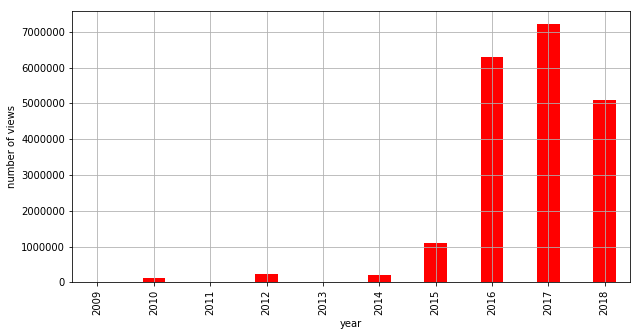

In [47]:
sf.plot_views_per_year(topic)

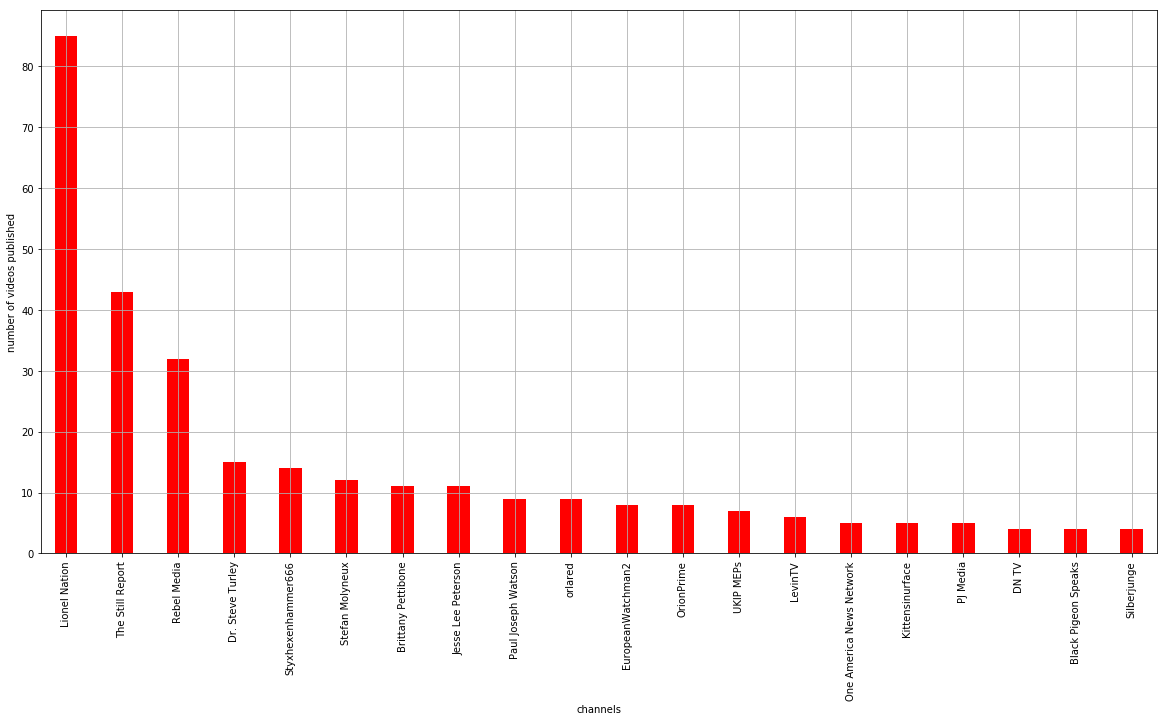

In [48]:
sf.plot_top_channels(topic)

### Antimoslim

In [15]:
query_topic = 'islam'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['calipha', 'jihad', 'islamis', 'islamic',
         'burqa', 'burka', 'prophet', 'muhamm', 'mohamm', '^islam$',
         'counter-jiha', 'counter jiha', 'contra jiha', 'contra-jiha',
         'kopvod', 'muslim', 'quran', 'koran', 'mosque', 'moskee',
        '^isis$', 'al qaed', 'al-qaed', 'infidel', 'dhimmi', 'sharia', 'robert spence',
        'tommy rob', '^is$', '^isil$', '^imam$', 'moschee', 'dawah', 'salaf']

In [16]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 14132 videos with islam


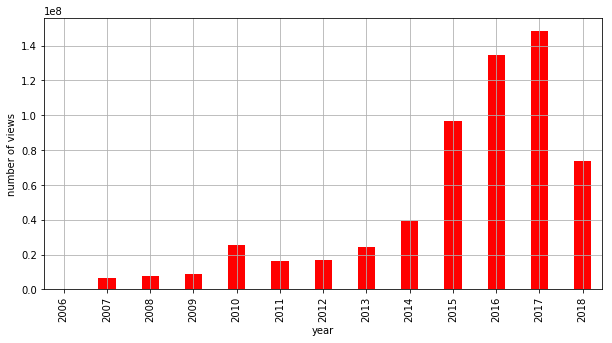

In [17]:
sf.plot_views_per_year(topic)

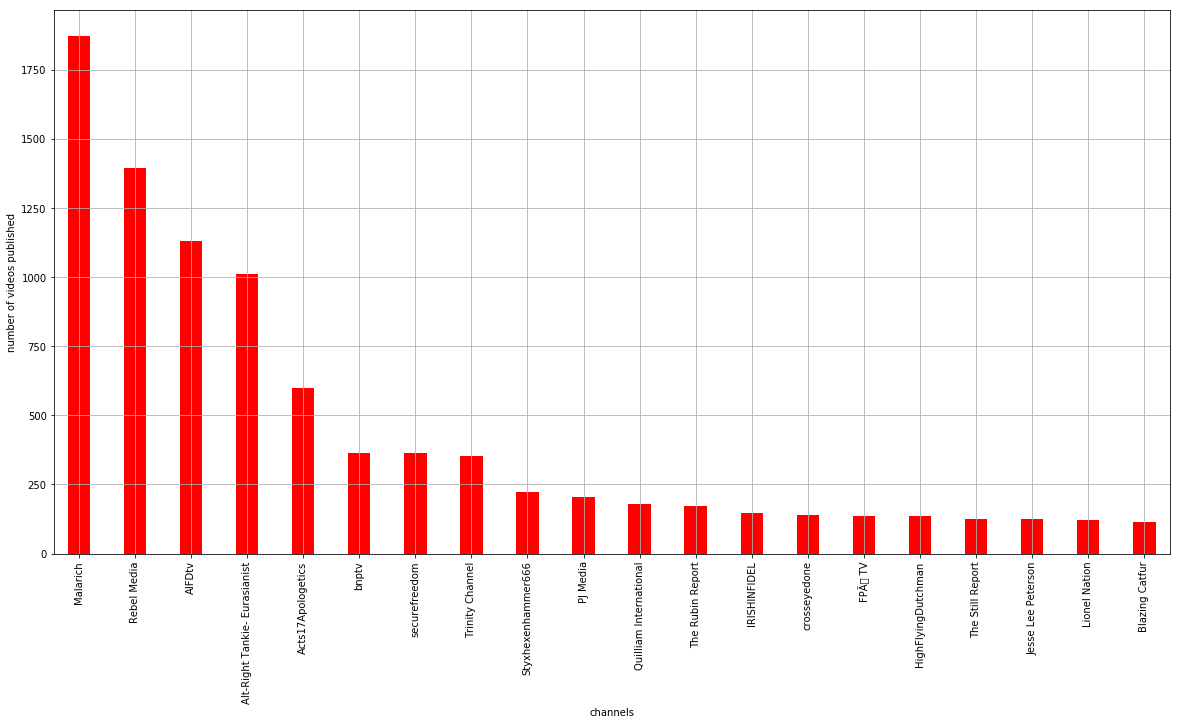

In [18]:
sf.plot_top_channels(topic)

In [19]:
malarich = topic[topic['video_channel_title'] == 'Malarich']
len(malarich)

1872

In [20]:
malarich

,video_id,video_published,channel_id,video_title,video_description,video_channel_title,video_tags,video_category_id,video_default_language,video_duration,video_view_count,video_comment_count,video_likes_count,video_dislikes_count,video_topic_ids,video_topic_categories,year,yearmonth
31394,JYpUBiNWAHk,2018-10-30T07:19:23.000Z,UCHI172C2wUtZPjuz5u99l-A,Protest gegen Pro-Islam-Propaganda im MÃ¼nchne...,In der Stadtinformation im MÃ¼nchner Rathaus l...,Malarich,"['Islam', 'Islamisierung Deutschlands', 'Koran...",25.0,not set,PT9M33S,25446.0,597.0,2055.0,65.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-10
31395,sFWBS7rQFPc,2018-10-28T20:22:02.000Z,UCHI172C2wUtZPjuz5u99l-A,Muslims pray in public in munich as a protest ...,"Munich, Stachus, 18.9.2018. About 20 muslims p...",Malarich,"['Islam', 'Koran', 'Prophet Mohammed', 'Islami...",25.0,not set,PT5M45S,23942.0,830.0,1193.0,120.0,"['/m/098wr', '/m/06bvp', '/m/098wr', '/m/06bvp']","['https://en.wikipedia.org/wiki/Religion', 'ht...",2018,2018-10
31396,qWvIJ2pxuug,2018-10-28T20:13:20.000Z,UCHI172C2wUtZPjuz5u99l-A,Anke Van dermeersch about Islam and Global pac...,Interview with Anke Van dermeersch from Vlaams...,Malarich,"['Islam', 'Prophet Mohammed', 'Islamisation', ...",25.0,not set,PT10M9S,2600.0,38.0,217.0,4.0,"['/m/098wr', '/m/05qt0', '/m/098wr', '/m/05qt0']","['https://en.wikipedia.org/wiki/Society', 'htt...",2018,2018-10
31397,iF84vXOAzu4,2018-10-19T08:47:33.000Z,UCHI172C2wUtZPjuz5u99l-A,Protest gegen die geplante DITIB-Moschee in Ma...,Auch in Marl bei Recklinghausen versucht die D...,Malarich,"['Islam', 'Islamisierung Deutschlands', 'Koran...",25.0,not set,PT1H14M,18502.0,601.0,1485.0,48.0,"['/m/098wr', '/m/05qt0', '/m/098wr', '/m/05qt0...",['https://en.wikipedia.org/wiki/Television_pro...,2018,2018-10
31398,GVO6xEJZWh4,2018-10-18T12:14:13.000Z,UCHI172C2wUtZPjuz5u99l-A,"âLasst Euch nicht zum Schweigen bringen"" - K...",Katie Hopkins war frÃ¼her Reporterin bei dem b...,Malarich,"['Islam', 'Islamisierung Deutschlands', 'Islam...",25.0,not set,PT59S,5263.0,113.0,454.0,31.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-10
31399,qLowaAhIDUs,2018-10-17T08:19:11.000Z,UCHI172C2wUtZPjuz5u99l-A,The Islam threat to Great Britain - Interview ...,Katie Hopkins was a reporter for the british T...,Malarich,"['Islam', 'Katie Hopkins', 'Islamisation', 'Gr...",25.0,not set,PT11M49S,9043.0,91.0,454.0,13.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-10
31401,DrdHBGBTOx4,2018-10-15T13:37:59.000Z,UCHI172C2wUtZPjuz5u99l-A,AfD-Bezirksvorsitzender Niederbayern Stephan P...,Interview mit dem AfD-Bezirksvorsitzenden Nied...,Malarich,"['Islamisierung Deutschlands', 'Islam', 'Bunde...",25.0,not set,PT8M22S,3870.0,60.0,191.0,7.0,"['/m/05qt0', '/m/098wr', '/m/098wr', '/m/05qt0']","['https://en.wikipedia.org/wiki/Politics', 'ht...",2018,2018-10
31408,6f9qYi_XN3g,2018-10-10T04:27:11.000Z,UCHI172C2wUtZPjuz5u99l-A,"Interview mit ""Fck Nazis""-Gegendemonstranten b...",Demo von linken Gegendemonstranten zur Compact...,Malarich,"['Islam', 'Islamisierung Deutschlands', 'Siche...",25.0,not set,PT5M54S,84897.0,1829.0,3782.0,206.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],2018,2018-10
31411,fgprEvY_ELg,2018-10-09T15:05:23.000Z,UCHI172C2wUtZPjuz5u99l-A,Die Wahrheit macht uns stark und wir setzen un...,"Rede von Michael StÃ¼rzenberger, Journalist be...",Malarich,"['Islam', 'Islamisierung Deutschlands', 'Koran...",25.0,not set,PT19M9S,3304.0,72.0,340.0,18.0,"['/m/098wr', '/m/06bvp', '/m/098wr', '/m/06bvp']","['https://en.wikipedia.org/wiki/Religion', 'ht...",2018,2018-10
31412,8R2d489syJ8,2018-10-09T14:28:21.000Z,UCHI172C2wUtZPjuz5u99l-A,"MigrantenverbÃ¤nde fordern ""Tag der Vielfalt"" ...","Rede von Michael StÃ¼rzenberger, Journalist be...",Malarich,"['Islam', 'Islamisierung Deutschlands', 'Tag d...",25.0,not set,PT14M5S,6354.0,174.0,456.0,13.0,"['/m/05qt0', '/m/098wr', '/m/098wr', '/m/05qt0'

### Vluchtelingen / migratie

In [22]:
query_topic = 'refugees_immigration'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['refugees', 'rapefugee', 'vlucht', 
         'asyl', 'asiel', 'asylu', 'gelukszoeke', 'flücht',
         'migrati', 'immigrat', 'migrant', 'immigrant', 'ausl',
         'frontex', 'border', 'azc', 'replacement', 'replace', 
         'kalergi', 'omvolking', 'integrat', 'invasion', 'invasie',
         'demograf', 'demograph'
        ]

In [23]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 10966 videos with refugees_immigration


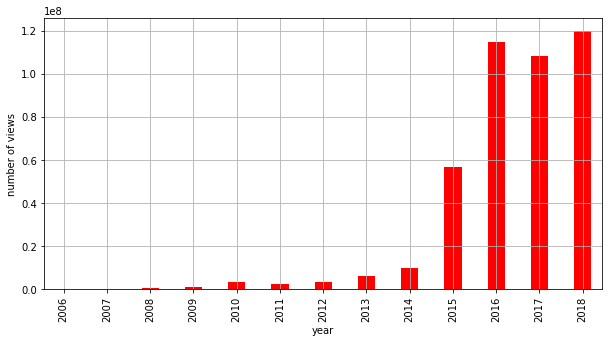

In [24]:
sf.plot_views_per_year(topic)

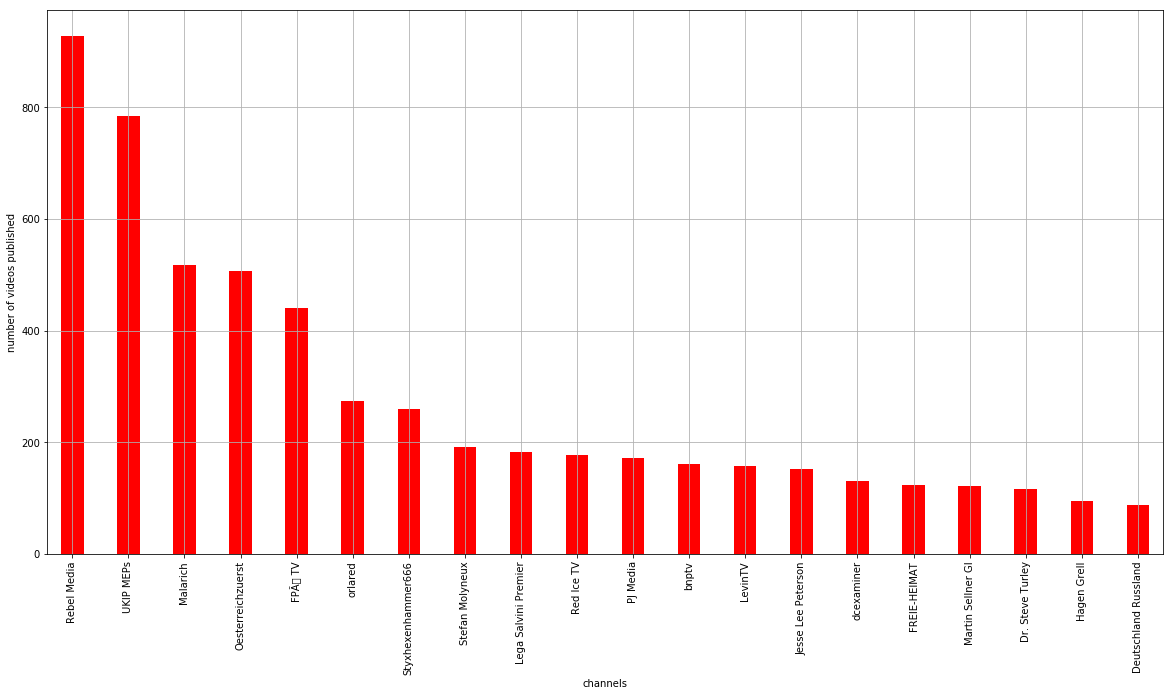

In [25]:
sf.plot_top_channels(topic)

In [27]:
query_topic = 'rapefugee'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['rapefugee']

In [28]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right = sf.add_years_months_to_videos(videos_right)
topic = sf.topic_filter(videos_right, query, query_topic)

found 17 videos with rapefugee


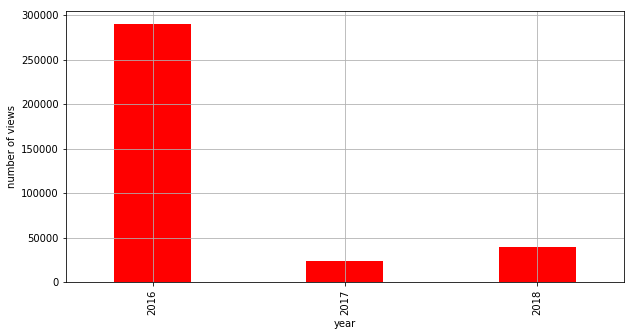

In [29]:
sf.plot_views_per_year(topic)

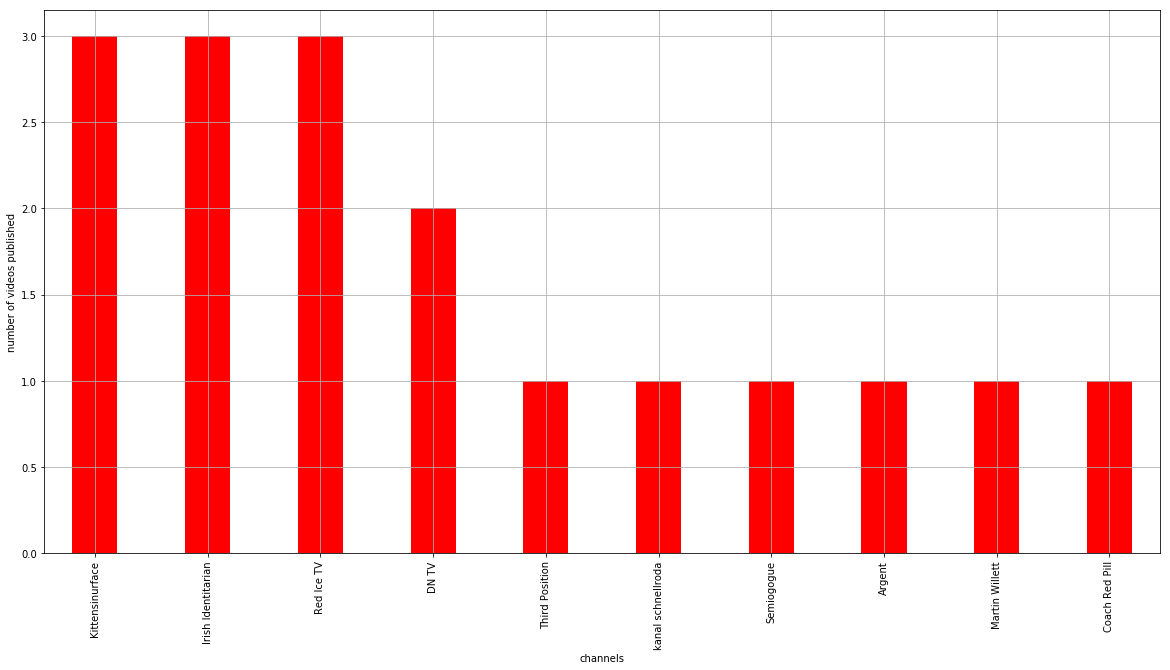

In [30]:
sf.plot_top_channels(topic)

#### PragerU

[Interessant filmpje](https://www.youtube.com/watch?v=stR5nWkq3LU) van Douglas Murray over 'the suicide of Europe'. Zeer gelikt filmpje, 3,5 miljoen keer bekeken. 

Of [Sweden as the rape capital of Europe.](https://www.youtube.com/watch?v=QCE_vEdA9WU) 

Duidelijke bias in alle filmpjes: conservatief, nationalistisch, anti-SJW.

### Varia

[Mimir's Head](https://www.youtube.com/watch?v=-QcD9gcPJ1s), the 6 principles of ethnonationalism. 

[Waffen Collider](https://www.youtube.com/watch?v=-UXqNysbNbI&t=4343s&bpctr=1545137905), Who controls the world

[Without white children we will perish](https://www.youtube.com/watch?v=Sojsoco_OsU), van WhiteDate Net.

[WE are the True israelites!?](https://www.youtube.com/user/ThuleanPerspective), van Thulean Perspectives, een Odinist. Apart filmpje met ook wel een paar grappige stukjes. Het kanaal heeft overigens 212 duizend abonnees. Een oude vent die wandelt. [Dit](https://www.youtube.com/watch?v=qYK3jPalOcc) komt toch wel dicht bij Hitler apologetica. Filmpje ook bruikbaar.

[traitorsbeware](https://www.youtube.com/watch?time_continue=60&v=A8HhnTOmvpQ) beschrijft haar eigen redpill moment. Mensen bestaan uit wakkere en niet-wakkere mensen. Heeft bijna 100.000 views gekregen. Zij heeft 13.000 subscribers. Mooi voorbeeld van een gekkie (I don't feel in this world anymore). Die vrouw heeft geestelijke problemen.

## Waar zitten de Nederlandse reaguurders? 

Ik heb een lijst met Nederlands klinkende namen, of namen waarvan aannemelijk is dat ze bij Nederlanders horen. Laten we eens kijken waar die gebruikers allemaal hebben gereageerd.

In [29]:

nl = ['A Stuijt',
    'Peter-john De Jong',
    'Adrie Van Dijk',
    'Akka Fietje',
    'Wouter Lensvelt',
    'Willem Sterk',
    'Michael Groenendijk',
    'Milo Overzicht',
    'Mike De Jong',
    'Mike Brink',
    'Nellie Rutten',
    'Paul van Dijck',
    'Peter Jongsma',
    'Piet Hein',
    'Pieter van der Meer',
    'Polder Cannabis Olie team',
    'Politiekman',
    'Raymond Doetjes',
    'Willem Pasterkamp',
    'Wimpiethe3',
    'Willie van het Kerkhof',
    'Vincent Vermeer',
    'Mark Tak',
    'Melvin Jansen',
    'Mark Kamphuis',
    'Tristan van Oosten',
    'Tom dGe-lugs-pa',
    'Tom Van de Pol',
    'Tom Van Gool',
    'Marcel Bruinsma',
    'Maarten van der Poel',
    'Maciano Van der Laan',
    'Tiemen Weistra',
    'TheRdamterror',
    'TheCitroenman1',
    'The flying dutchman',
    'Teun de Heer',
    'Stijn van de Ven',
    'Sjaak v Koten',
    'Sev Vermeer',
    'Tanya De Beer',
    'Tim Pietersen',
    'Alan Holland',
    'Bennie Leip',
    'Bert Prins',
    'Bestheftig',
    'Borisje Boef',
    'Chris Van Bekkum',
    'Coen Bijpost',
    'Cornelis van der Heijden',
    'David Teunissen',
    'David Van der Tweel',
    'De Veelvraat',
    'Dennis Bouma',
    'Dennis Eijs',
    'Donald gekkehenkie',
    'peter van',
    'onbekende telefoon',
    'nick van achthoven',
    'mikedehoogh black flag race photos',
    'kristof verbruggen',
    'jan holdijk',
    'jan Yup',
    'iwan munnikes',
    'hans van de mortel',
    'geroestetumor',
    'geheimschriver',
    'gaatje niksaan',
    'dutchmountainsnake',
    'dutch menneer',
    'donder bliksem',
    'boereriem',
    'appie D',
    'adam willems',
    'Yuri Klaver',
    'zuigdoos',
    'yvonneforsmanatyahoo',
    'vanhetgoor',
    'theflyingdutchboi',
    'r juttemeijer',
    'rutger houtdijk',
    'Dutch Patriot',
    'Dutch Whitey',
    'DutchFurnace',
    'Esias Lubbe',
    'Ewalds Eiland',
    'Joey Kuijs',
    'Faust',
    'Hollandia777',
    'Johan van Oldenbarnevelt',
    'Keescanadees',
    'Geert Kok',
    'Haasenpad',
    'Henk Damster',
    'Henk van der Laak',
    'Henri Zwols',
    'Haat Praat',
    'Gerard Mulder',    
    'Grootmeester Jan',
    'H. v. Heeswijk',
    'B. Hagen',
    '1234Daan4321',
    'Daniella Thoelen', 
    'Diederik',
    'Linda Bostoen', 
    'Christiaan Baron', 
    'Matthijs van Guilder',
    'Johannes Roose',
    'Deon Van der Westhuizen', 
    'Remko Jerphanion', 
    'Roosje Keizer',
    'Dennis Durkop',
    'ivar olsen',
    'Pete de pad',
    'georgio jansen',
    'Joel Peter',
    'Antonie de Vry',
    'Stijn Voorhoeve', 
    'liefhebber179',
    'Walter Taljaard',
    'joe van gogh',
    'Edo Peter', 
    'Ad Lockhorst',
    'kay hoorn',
    'Erik Bottema',
    'Deplorable Data',
    'JESSEverything',
    'Harry Balzak', 
    'Bokkepruiker Records',
    'zonnekat',
    'Peter-john De Jong',
    'marco mac',
    'Joubert x',
    'Natasja van Dijk',
    'Voornaam Achternaam',
    'hermanPla', 
    'M. van der Scheer',
    'gerald polyak',
    'Robbie Retro',
    'Johannes DeMoravia',
    'Wouter Vos',
    'AwoudeX',
    'carolineleiden',
    'A-dutch-Z',
    'piet ikke',
    'kutbleat',
    'David of Yorkshire',
    'Gert Tjildsen',
    'Flying Dutchman',
    'Visko Van Der Merwe',
    'Blobbejaan Blob',
    'TheBergbok',
    'jknochel76',
    'Olleke Bolleke',
    'demarcation',
    'Nayako Sadashi',   
    'er zaal',
    'jhon jansen',
    '-____-',
    'Brummie Brink',
    'reindeerkid ',
    'Pagan Cloak',
    'NDY',
    'Karel de Kale',
    'top top',
    'Chris Veenendaal ',
    'MijnheerlijkeBuitenlandse befkut ,',
    'Kevin Zilverberg',
    'Rick Dekker ',
    'Adrie Van Dijk ',
    'miep miep',
    'pronto ',
    'TheUnTrustable0',
    'danny schaap',
    'Mark Mathieu',
    'Raysboss302',
    'Ruud Hooreman',
    'Willie W',
    'Barend Borrelworst',
    'theo breytenbach',
    'coinmaster1000 coinmaster1000',
    'Kevin Zilverberg',
                     ]

In [ ]:
nl_nl = sf.get_comments_by_author_name(nl, 'nl_right')

In [ ]:
nl_right = sf.get_comments_by_author_name(nl, 'right')

In [ ]:
nl_left = sf.get_comments_by_author_name(nl, 'left')

In [ ]:
videos_nl = pd.read_csv(path_nl + 'videos_nl_right.csv', encoding='latin-1')

In [ ]:
nl_nl = pd.merge(nl_nl, videos_nl[['video_id', 
                                'video_channel_title',
                                'video_tags',
                                'video_view_count',
                                'video_comment_count']], on='video_id', how='left')

In [ ]:
videos_left = pd.read_csv(path_left + 'videos_left.csv', encoding='latin-1')
nl_left = pd.merge(nl_left, videos_left[['video_id', 
                                'video_channel_title',
                                'video_tags',
                                'video_view_count',
                                'video_comment_count']], on='video_id', how='left')

In [ ]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
nl_right = pd.merge(nl_right, videos_right[['video_id', 
                                'video_channel_title',
                                'video_tags',
                                'video_view_count',
                                'video_comment_count']], on='video_id', how='left')

In [ ]:
nl_total = nl_nl.append([nl_left, nl_right], sort=False)

In [ ]:
nl_total.head()

In [ ]:
nl_total.to_csv(path_nl + 'nl_total_comments.csv')

In [ ]:
nl_total = pd.read_csv(path_nl + 'nl_total_comments.csv')

## Gewelddadige retoriek in comments

Kunnen we comments vinden waarin opgeroepen wordt tot geweld? 

In [39]:
query_hate_speech = ['^bitch', '^cunt', 'faggot', '^fag$', '^dyke', '^kike', '^nigger',
                     '^whore', '^cink', 'porch monk', 'wetbacks', 'nigga', 'piece of shit', 
                     '^coon','^spic$', 'jew bastar', 'savages', 'fuck them', 'fuck you',
                     '^slut$', 'kangz', 'dindu nuf', '^goyim', '^shekels',
                     'globalist', 'fuck her', 'feminazi',
                    
                    ]

query_hate_speech_nl = ['kanker', '^hoer', '^slet$', 'nikker', 'vuile jood', 
                        'vuile moslim', 'tyfus', '^neger$', 'zwarte aap', 
                        '^tering', 'vieze jood', '^kut', 'val dood', 'ga dood',
                        'dat je doodgaat', 'kk marokkaan', 'kk mocro' , 'parasieten', 'ratten$',
                       '^tuig', 'afknallen', 'vieze jood', 'vieze jodi', 'beurt nodig',
                        'ik zou haar doen', 'zou je haar doen', 'grafhoer',
                        'globalist', 'klootzak', 'haatbaard', '^hakbar',
                        'dobberneger', 'stoephoer', 
                       
                       ]

query_violence_nl = ['ze doodmaken', 'in opstand komen', 'tijd voor actie', 'genoeg is genoeg', 
                    'ze verdelgen', 'ze vernietigen', 'geen gelul meer', 'ik je verkrachten', 'je neuken',
                     'ze vergassen', 'leg ze aan het gas', 'trein naar het oosten',
                     'maak ze dood', 'dit is oorlog', 'tijd voor oorlog', 'praten is voorbij'
                     
                    ]
    
        
query_violence = ['we should kill', 'i want to rape', 'this is war', 'enough is enough',
                  'talking is over', 'time for action', 'stand up and fight','should be raped',
                  'should be killed', 'should kill','should punch', 'should murder', 'i will kill',
                    'i will hurt', 'kill them all','kill those savages', "i'm going to shoot",
                  "i'm going to kill", "i'm going to rape", 'need to punish', 'i will punish',
                  'kill yourself', 'be hanged', 'time to fight', "let's fight", 'hope you get killed',
                  'hope you get raped', 'lynch them', 'exterminate', 'destroy them', 'deport them',
                  'rape them', 'shoot them', 'punish them', 'hang them', "i'll kill"
                 ]


In [40]:
hate_speech = query_hate_speech + query_hate_speech_nl
violent_speech = query_violence + query_violence_nl

In [ ]:
violence_right = sf.get_comments_by_topic(violent_speech, 'right')

In [41]:
violence_left = sf.get_comments_by_topic(violent_speech, 'left')

found 130872 comments 
 and 87245 unique commenters


In [42]:
violence_left.to_csv(path_viz + 'violence_left.csv')

In [43]:
violence_nl_right = sf.get_comments_by_topic(violent_speech, 'nl_right')

sphere not found 
please try again
found 616 comments 
 and 545 unique commenters


In [44]:
violence_nl_right.to_csv(path_viz + 'violence_nl_right.csv')

[autoreload of six failed: Traceback (most recent call last):
  File "/home/dim/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/dim/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 392, in superreload
    update_generic(old_obj, new_obj)
  File "/home/dim/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/home/dim/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 274, in update_class
    old_obj = getattr(old, key)
  File "/home/dim/.local/lib/python3.6/site-packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]


In [ ]:
violence.to_csv(path_viz + 'violence_right.csv')

In [4]:
violence_right = pd.read_csv(path_viz + 'violence_right.csv')

In [6]:
violence_left = pd.read_csv(path_viz + 'violence_left.csv')

In [7]:
violence_nl = pd.read_csv(path_viz + 'violence_nl_right.csv')

In [13]:
violence = violence_right.append([violence_left, violence_nl], sort=False)

In [15]:
violence = violence.drop_duplicates()

In [16]:
len(violence)

210506

In [19]:
violence.author_channel_id.value_counts()

UCkOj7XTcoS1Zblqf5QPw7jw    282
UCNSNfg1KcQHUQooAsG0v5aA    238
UCE8IKZ_zQW0V3FzNrDwqoXQ    234
UCeFYTc6gDyULkK5fL0Js4cw    193
UCDLUm65Mg7gVJ4NrQg_ugDQ    184
UCR-0DAyxZzGvb4p6CpysQyA    164
UCe6ZE68dIEQJCbfbDQ5BttQ    154
UCoDy1CTbSkQsx3y7_lSbFrQ    137
UClTbh9Tn_enZKBohkvwMz5A    111
UCxj_wkKYdKN0MErTS3ShZBQ    110
UC2sTOZuaYiYhzy6Lxt2M6Vw    100
UCZR19TJ6o4xecQYeb68EUMg     92
UCW_1MqlxisKMS_D_tsWPrZQ     92
UCgmUIfhW67KYleS2etCUZlg     89
UCvSNEuojpGTdzmpyGHUOrTA     82
UCDmGYRXb0SoMt9iKCn4CIQA     81
UCPXqeD9fNxGJmRfspYVNVTQ     78
UCitsXymBrUrd_OGs_WrEY1A     74
UCfjsw1mKExfycmSUgRUquhg     72
UCaDOD_qQery5oTnNilotfQw     70
UC7K0Xr0qTONdQ8eZu995tLg     69
UCgWeocqeTrs2CdbQkzIlIrw     68
UCKOcdcjtEO5h-54mBWXXwrg     67
UCMwf5cNViMb4cbEfZ1SzpaA     66
UCmHHSg4Ykkq6yTlzyZejvKg     63
UCMA1xU50PLiHXL00g0_xY3Q     62
UCq5ILnmAPmlBUlhZCX2QCJQ     62
UCe7KJXegOMYLAOv5EINuxaQ     59
UCiTI0Osb567pjGzHqD3pzZw     59
UChs3Bej3QXicdThw5poQ23g     58
                           ... 
UCxz6B7o

In [31]:
result = violence[violence['author_channel_id'] == 'UCgmUIfhW67KYleS2etCUZlg']
for f in result.comment_text:
    print(f)

Elections are a 1 man 1 vote system. Let in too many refugees/illegals and you risk being outvoted. (legally or illegally.) Remember... they will reproduce too. Also... if terrorists and criminals are hidden among refugees, they could gradually increase in numbers and vote their agents into your government. This causes social problems which in turn ruins your economy too. Every country&#39;s government must be responsible for their own people, not let foreign nations care for them. Accepting refugees/illegals encourages their corrupt governments to continue ill treating its citizens. Deport them. There are other ways to help.
Elections are a 1 man 1 vote system. Let in too many refugees/illegals and you risk being outvoted. (legally or illegally.) Remember... they will reproduce too. Also... if terrorists and criminals are hidden among refugees, they could gradually increase in numbers and vote their agents into your government. This causes social problems which in turn ruins your econ

In [29]:
result

,Unnamed: 0,video_id,comment_id,author_display_name,author_channel_id,comment_text,comment_time,year,sphere
354,155690,utl74wobvgw,UgyMNUWH5CKHFOGOEax4AaABAg.8krKgTUf9EF8l1EGGPWNhm,Jennifer Nova,UCxj_wkKYdKN0MErTS3ShZBQ,These &quot;&quot;ROTHSCHILD&quot;&quot; ashk...,2018-09-10T19:59:26.000Z,2018.0,right
355,155790,utl74wobvgw,UgxqEttMm7EiQ0lLdMh4AaABAg.8krE4grHPBt8l184Oh4iyl,Jennifer Nova,UCxj_wkKYdKN0MErTS3ShZBQ,+alternate account Here is how their &quot;&qu...,2018-09-10T19:05:23.000Z,2018.0,right
1074,449541,pJPoOBWPXDI,UgyanS4qdGmq5gkdYCR4AaABAg.8kZmQsWdnJL8lbsTN1MS0X,Jennifer Nova,UCxj_wkKYdKN0MErTS3ShZBQ,Exactly !! Its like feeding the very paras...,2018-09-25T10:51:23.000Z,2018.0,right
1075,449611,pJPoOBWPXDI,UgzdDX5VYwbro4iiZOp4AaABAg.8kYf70ijRPx8lbn4IXqmqZ,Jennifer Nova,UCxj_wkKYdKN0MErTS3ShZBQ,+unmarkedX It will never happen until we ex...,2018-09-25T10:04:17.000Z,2018.0,right
8676,3870342,LeEVt_w_AdE,UgjWr0LgiWNEH3gCoAEC.8TDpNs0cqVN8l1Xu63jZUw,Jennifer Nova,UCxj_wkKYdKN0MErTS3ShZBQ,Here is how their &quot;&quot;KALERGI PLAN&quo...,2018-09-10T22:51:02.000Z,2018.0,right
10546,4411346,UJaGYcVFIVY,UggEO1HBvXYcmXgCoAEC.8RE7BL0S1JX8lKnhzS5aKO,Jennifer Nova,UCxj_wkKYdKN0MErTS3ShZBQ,Here is how their &quot;&quot;KALERGI PLAN&quo...,2018-09-18T10:23:30.000Z,2018.0,right
13071,5212449,ak6exfOwji4,UgyKdXl8ExY1sVMaeTR4AaABAg.8mbZ3L30AkG8nPUZP55q_2,Jennifer Nova,UCxj_wkKYdKN0MErTS3ShZBQ,+I Need Real Proof These so called Jews aka se...,2018-11-08T23:06:25.000Z,2018.0,right
13072,5212460,ak6exfOwji4,Ugx5dX0yDSVJ9oQa5Vt4AaABAg.8mbY1EdcddX8nDNwLZYF8o,Jennifer Nova,UCxj_wkKYdKN0MErTS3ShZBQ,"Its now become imperative , for Europeans to b...",2018-11-04T06:17:38.000Z,2018.0,right
13073,5212463,ak6exfOwji4,Ugy2l3cXyT8WUdGvVkt4AaABAg.8mbXWgJ0WjF8nDO-BzdJYI,Jennifer Nova,UCxj_wkKYdKN0MErTS3ShZBQ,These so called Jews aka semites aka chosen pe...,2018-11-04T06:18:10.000Z,2018.0,right
13074,5212589,ak6exfOwji4,Ugzd4k5N7yGe2hDYfCl4AaABAg.8mb9VXyaKWb8nDOqFS1KB9,Jennifer Nova,UCxj_wkKYdKN0MErTS3ShZBQ,Here is how their &quot;&quot;KALERGI PLAN&quo...,2018-11-04T06:25:33.000Z,2018.0,right
